In [2]:
##debug self.label_tree()
##vocab production script
#imports
import multiprocessing
from multiprocessing import Pool
import math, random, sys
import pickle
import argparse
from functools import partial
import torch
import numpy
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from hgraph import MolGraph, common_atom_vocab, PairVocab
import rdkit
import rdkit.Chem as Chem
import networkx as nx
from hgraph.chemutils import *
from hgraph.nnutils import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG
import time
from rdkit.Chem import Draw
import itertools
from collections import Counter

# IPythonConsole.drawOptions.addAtomIndices = True
# IPythonConsole.molSize = 300,300

#test: this change should only appear in the 'peptide' branch

/home/marcase/.conda/envs/hgraph-rdkit/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


clusters are wrong somehow


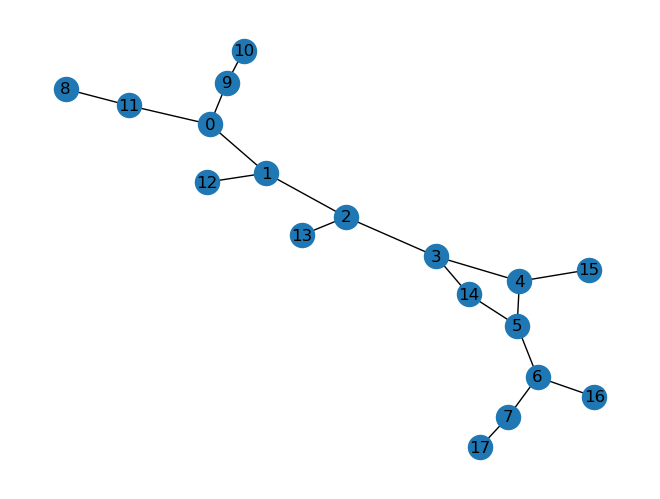

0

In [3]:
###putting it all together: one shot graph generation
peptide = 'N[C@@H](CO)C(=O)N[C@@H](CSCC(C4)=O)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CO)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CS4)C(=O)O'
mol = get_mol(peptide)
n_atoms = mol.GetNumAtoms()
if n_atoms == 1: #special case
    print('1 atom')
    
# def mol_with_atom_index(mol):
#     for atom in mol.GetAtoms():
#         atom.SetAtomMapNum(atom.GetIdx())
#     return mol

# mol_with_atom_index(mol)
# Draw.MolToFile(mol, "peptide.png",fitImage=True,size=(6000,6000))

#separately define proline, because the backbone creates double recognition
proline = 'O=CC1CCCN1'
proline_matches = mol.GetSubstructMatches(Chem.MolFromSmiles(proline),useChirality=True)

#find all amino acids
amino_acid_motif = 'NCC=O'
matches = mol.GetSubstructMatches(Chem.MolFromSmiles(amino_acid_motif),useChirality=True)

#get matches with overlapping nitrogens for cluster identification (this method will not get the C-terminal amino acid)
amino_acid_n = 'NCC(=O)N'
matches_n = mol.GetSubstructMatches(Chem.MolFromSmiles(amino_acid_n),useChirality=True)
matches_n = [match_n for match_n in matches_n]

#get matches with overlapping carboynl oxygens for cluster identification (this method will not get the N-terminal amino acid)
amino_acid_c = 'O=CCNC'
matches_c = mol.GetSubstructMatches(Chem.MolFromSmiles(amino_acid_c),useChirality=True)

#find matches that aren't prolines
if len(proline_matches) == 0:
    matches_without_prolines = matches
    matches_n_no_prolines = matches_n
    matches_c_no_prolines = matches_c
    backbone_atoms = np.hstack(np.unique(np.concatenate((np.hstack(matches_n_no_prolines),np.hstack(matches_c_no_prolines),np.hstack(mol.GetSubstructMatches(Chem.MolFromSmiles('NCC(O)=O'),useChirality=True))))))
else:
    matches_without_prolines = [match for match in matches if not any([x in np.hstack(proline_matches) for x in match])]
    matches_n_no_prolines = [match for match in matches_n if sum([x in np.hstack(proline_matches) for x in match]) < 2]
    matches_c_no_prolines = [match for match in matches_c if sum([x in np.hstack(proline_matches) for x in match]) < 2]
    backbone_atoms = np.hstack(np.unique(np.concatenate((np.hstack(matches_n_no_prolines),np.hstack(matches_c_no_prolines),np.hstack(proline_matches),np.hstack(mol.GetSubstructMatches(Chem.MolFromSmiles('NCC(O)=O'),useChirality=True))))))

#split up side chain atoms and backbone atoms
sidechain_atoms = np.setdiff1d(np.array(range(1,n_atoms)),backbone_atoms)

#identify the c and n terminus by finding where the amino acid backbone begins and ends
matches_double_overlap = mol.GetSubstructMatches(Chem.MolFromSmiles('NCC(NCC=O)=O'),useChirality=True)
matches_double_overlap = [m for m in matches_double_overlap if not any([x in sidechain_atoms for x in m])]
count = Counter(np.hstack(matches_double_overlap))
matches_double_overlap = [m for m in matches_double_overlap if not all(count[x] > 1 for x in m )]
if len(matches_double_overlap) == 2:
    n_terminus = [x for x in matches_double_overlap[0] if count[x] == 1]
    c_terminus = [x for x in matches_double_overlap[1] if count[x] == 1]
else:
    print('could not identify termini correctly')

#identify the termini clusters
#nterm cluster
if len(proline_matches) != 0 and any([x in np.hstack(proline_matches) for x in n_terminus]): #n_terminus is a proline
        n_terminus = [np.array(proline) for proline in proline_matches if any([x in n_terminus for x in proline])][0]
else: #n_terminus is not a proline
    n_terminus = [np.array(match) for match in matches if any([x in n_terminus for x in match])][0]

#cterm cluster
if len(proline_matches) != 0 and any([x in np.hstack(proline_matches) for x in c_terminus]):
        c_terminus = np.array(mol.GetSubstructMatches(Chem.MolFromSmiles('CN1[C@H](C(O)=O)CCC1'),useChirality=True))[0]
else: #c terminus is not a proline
    c_terminus = np.array(mol.GetSubstructMatches(Chem.MolFromSmiles('CNCC(=O)O'),useChirality=True))[0]

#non-terminus prolines
prolines_non_terminal = [proline for proline in proline_matches if sum([(x in c_terminus) or (x in n_terminus) for x in proline]) < 3]
if len(prolines_non_terminal) > 0:
    prolines_not_terminal_overlap = mol.GetSubstructMatches(Chem.MolFromSmiles('O=CC1CCCN1C'),useChirality=True)
    prolines_not_terminal_overlap = [proline for proline in prolines_not_terminal_overlap if any([x in np.hstack(prolines_non_terminal) for x in proline])]
else:
    prolines_not_terminal_overlap = []

#define clusters from backbones, the termini, and any prolines
clusters = list()
[clusters.append(match) for match in matches_c_no_prolines if sum([x in c_terminus for x in match]) < 2]
clusters.append(tuple(c_terminus))
clusters.append(tuple(n_terminus))
[clusters.append(proline) for proline in prolines_not_terminal_overlap]

#define alpha carbons and sets of backbone/ sideatoms without and with them
c_alphas = np.array(matches)[:,1]
c_alphas_neighbors = [mol.GetAtomWithIdx(int(x)).GetNeighbors() for x in c_alphas]
sidechain_atoms_with_calphas = np.union1d(sidechain_atoms,c_alphas)
backbone_atoms_without_calphas = np.setdiff1d(backbone_atoms,c_alphas)

##recursively identify alpha carbons, and map the atom indices that contain their side chains
for index,c_alpha in enumerate(c_alphas): #iterate throguh each alpha carbon
    c_alpha_neighbors = mol.GetAtomWithIdx(int(c_alpha)).GetNeighbors() #get the neighbors of given c_alpha. serves as starting point for molecular search
    if len(proline_matches) != 0 :
        if c_alpha in np.hstack(proline_matches):
            continue
    for neighbor in c_alpha_neighbors: #for each atom next to a c_alpha, traverse it if it's not a backbone atom and it's also a carbon
        if (neighbor.GetIdx() not in backbone_atoms) and (neighbor.GetAtomicNum() == 6):
            side_chain_atoms = np.array([neighbor.GetIdx()]) #define the side chain of this c_alpha as a set, starting over at each new c_alpha
            new_neighbors = neighbor.GetNeighbors() # atoms to explore
            atoms_to_examine = np.array([]) #next atoms to explore
            while(len(new_neighbors) > 0): #if there are new neighbors from the previous step, proceed with side chain traversal
                for new_neighbor in new_neighbors:
                    if (new_neighbor.GetIdx() in c_alphas) and (new_neighbor.GetIdx() not in sidechain_atoms): #if the next atom is a c_alpha, include it (this works for non-stapled and stapled residues)
                        side_chain_atoms = np.append(side_chain_atoms,new_neighbor.GetIdx())
                    elif (new_neighbor.GetIdx() not in side_chain_atoms) and (new_neighbor.GetIdx() not in backbone_atoms): #if it's a regular side chain, add it, and all the new neighbors
                        side_chain_atoms = np.append(side_chain_atoms,new_neighbor.GetIdx())
                        atoms_to_examine = np.append(atoms_to_examine,new_neighbor.GetIdx())
                    elif new_neighbor.GetIdx()  in side_chain_atoms: #skip previously explored side chain atoms
                        continue
                    elif new_neighbor.GetIdx() in backbone_atoms: #skip previously explored backbone atoms
                        continue
                if len(atoms_to_examine) == 0: #if there's no more atoms to examine, end traversal
                    break
                else:
                    new_neighbors = np.hstack([mol.GetAtomWithIdx(int(atom)).GetNeighbors() for atom in atoms_to_examine]) #define the next step of neighbors as the atoms to examine
                    atoms_to_examine = np.array([])
            if sum([x in np.hstack(clusters) for x in side_chain_atoms]) < 3: #if most of this side chain has already been added as a cluster, do not add it (this commonly happens when a stapled side chain is traversed from both sides)
                clusters.append(tuple([x for x in side_chain_atoms]))

#convert cluster atoms to int
cluster = [tuple([int(atom) for atom in cluster]) for cluster in clusters]


#for each atom in the molecule, find which clusters it's a part of
atom_cls = [[] for i in range(n_atoms)]
for i in range(len(clusters)):
    for atom in clusters[i]:
        atom_cls[int(atom)].append(i)

#check cluster validity
if len(set(np.hstack(clusters))) != len(mol.GetAtoms()):
    print('clusters are wrong somehow')
    
#draw graph
graph = nx.empty_graph( len(clusters) )
for atom, nei_cls in enumerate(atom_cls):
    if len(nei_cls) <= 1: continue
    bonds = [c for c in nei_cls if len(clusters[c]) == 2]
    rings = [c for c in nei_cls if len(clusters[c]) > 4] #need to change to 2

    if len(nei_cls) > 2 and len(bonds) >= 2:
        clusters.append([atom])
        c2 = len(clusters) - 1
        graph.add_node(c2)
        for c1 in nei_cls:
            graph.add_edge(c1, c2, weight = 100)

    elif len(rings) > 2: #Bee Hives, len(nei_cls) > 2 
        clusters.append([atom]) #temporary value, need to change
        c2 = len(clusters) - 1
        graph.add_node(c2)
        for c1 in nei_cls:
            graph.add_edge(c1, c2, weight = 100)
    else:
        for i,c1 in enumerate(nei_cls):
            for c2 in nei_cls[i + 1:]:
                inter = set(clusters[c1]) & set(clusters[c2])
                graph.add_edge(c1, c2, weight = len(inter))

n, m = len(graph.nodes), len(graph.edges)
nx.draw(graph,with_labels=True)
plt.show()
n-m

In [15]:
prolines_non_terminal = [proline for proline in proline_matches if sum([(x in c_terminus) or (x in n_terminus) for x in proline]) < 3]
prolines_not_terminal_overlap = mol.GetSubstructMatches(Chem.MolFromSmiles('O=CC1CCCN1C'),useChirality=True)
prolines_not_terminal_overlap = [proline for proline in prolines_not_terminal_overlap if any([x in np.hstack(prolines_non_terminal) for x in proline])]
prolines_not_terminal_overlap

[(81, 80, 76, 77, 78, 79, 75, 73)]

In [4]:
atom_cls

[[9],
 [9, 10],
 [10],
 [10],
 [0, 9],
 [9],
 [0],
 [0, 11],
 [11],
 [11],
 [11],
 [11],
 [11],
 [11],
 [0, 1],
 [0],
 [1],
 [1, 12],
 [12],
 [12],
 [12],
 [12],
 [12],
 [12],
 [12],
 [1, 2],
 [1],
 [2],
 [2, 13],
 [13],
 [13],
 [13],
 [13],
 [13],
 [13],
 [13],
 [2, 3],
 [2],
 [3],
 [3, 14],
 [14],
 [14],
 [3, 4],
 [3],
 [4],
 [4, 15],
 [15],
 [15],
 [4, 5],
 [4],
 [5],
 [5, 14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [5, 6],
 [5],
 [6],
 [6, 16],
 [16],
 [16],
 [16],
 [16],
 [6, 7],
 [6],
 [7],
 [7, 17],
 [17],
 [17],
 [17],
 [7],
 [7],
 [],
 [],
 [],
 [],
 [],
 [8],
 [],
 [8],
 [8, 11],
 [11],
 [11],
 [8],
 [8],
 [8]]

In [149]:
#dfs method from mol_graph original
def dfs(order, pa, prev_sib, x, fa):
    pa[x] = fa 
    sorted_child = sorted([ y for y in mol_tree[x] if y != fa ]) #better performance with fixed order
    for idx,y in enumerate(sorted_child):
        if ((x,y,1) in order) or ((y,x,1) in order):
            # print('trying to add duplicate path to order')
            continue
        else:
            mol_tree[x][y]['label'] = 0 
            mol_tree[y][x]['label'] = idx + 1 #position encoding
            prev_sib[y] = sorted_child[:idx] 
            prev_sib[y] += [x, fa] if fa >= 0 else [x]
            order.append( (x,y,1) )
            dfs(order, pa, prev_sib, y, x)
            # print((y,x,0))
            order.append( (y,x,0) )

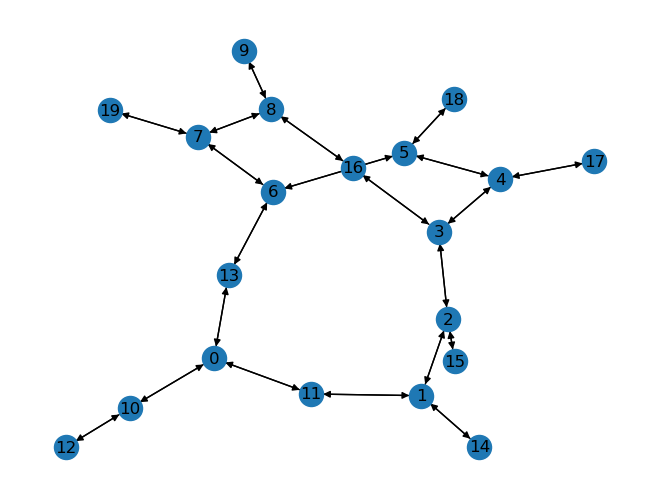

In [150]:
##everything else from label_tree() method
order, pa = [], {}
mol_tree = nx.DiGraph(graph)
nx.draw(mol_tree,with_labels=True)
plt.show()
prev_sib = [[] for i in range(len(clusters))]
dfs(order, pa, prev_sib, 0, -1)
order
order.append( (0, None, 0) ) #last backtrack at root

In [162]:
order

[(0, 10, 1),
 (10, 12, 1),
 (12, 10, 0),
 (10, 0, 0),
 (0, 11, 1),
 (11, 1, 1),
 (1, 2, 1),
 (2, 3, 1),
 (3, 4, 1),
 (4, 5, 1),
 (5, 6, 1),
 (6, 7, 1),
 (7, 8, 1),
 (8, 9, 1),
 (9, 8, 0),
 (8, 16, 1),
 (16, 3, 1),
 (3, 16, 0),
 (16, 8, 0),
 (8, 7, 0),
 (7, 19, 1),
 (19, 7, 0),
 (7, 6, 0),
 (6, 13, 1),
 (13, 0, 1),
 (0, 13, 0),
 (13, 6, 0),
 (6, 5, 0),
 (5, 18, 1),
 (18, 5, 0),
 (5, 4, 0),
 (4, 17, 1),
 (17, 4, 0),
 (4, 3, 0),
 (3, 2, 0),
 (2, 15, 1),
 (15, 2, 0),
 (2, 1, 0),
 (1, 14, 1),
 (14, 1, 0),
 (1, 11, 0),
 (11, 0, 0),
 (0, None, 0)]

In [161]:
pa

{0: 13,
 10: 0,
 12: 10,
 11: 0,
 1: 11,
 2: 1,
 3: 16,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 16: 8,
 19: 7,
 13: 6,
 18: 5,
 17: 4,
 15: 2,
 14: 1}

In [163]:
prev_sib

[[13, 6],
 [11, 0],
 [1, 11],
 [16, 8],
 [3, 2],
 [4, 3],
 [5, 4],
 [6, 5],
 [7, 6],
 [8, 7],
 [0],
 [10, 0],
 [10, 0],
 [7, 6, 5],
 [2, 1, 11],
 [3, 2, 1],
 [9, 8, 7],
 [5, 4, 3],
 [6, 5, 4],
 [8, 7, 6]]

In [154]:
#get mol_graph from build_mol_graph()
mol = get_mol(peptide)
graph = nx.DiGraph(Chem.rdmolops.GetAdjacencyMatrix(mol))
for atom in mol.GetAtoms():
    graph.nodes[atom.GetIdx()]['label'] = (atom.GetSymbol(), atom.GetFormalCharge())

for bond in mol.GetBonds():
    a1 = bond.GetBeginAtom().GetIdx()
    a2 = bond.GetEndAtom().GetIdx()
    btype = MolGraph.BOND_LIST.index( bond.GetBondType() )
    graph[a1][a2]['label'] = btype
    graph[a2][a1]['label'] = btype
    
mol_graph = graph

In [155]:
mol = get_mol(peptide)
for a in mol.GetAtoms():
    a.SetAtomMapNum( a.GetIdx() + 1 )

tree = mol_tree
for i,cls in enumerate(clusters):
    print(cls)
    cls = [int(cl) for cl in cls]
    inter_atoms = set(cls) & set(clusters[pa[i]]) if pa[i] >= 0 else set([0])
    inter_atoms = set([int(inter_atom) for inter_atom in inter_atoms])
    cmol, inter_label = get_inter_label(mol, cls, inter_atoms)
    tree.nodes[i]['ismiles'] = ismiles = get_smiles(cmol)
    tree.nodes[i]['inter_label'] = inter_label
    tree.nodes[i]['smiles'] = smiles = get_smiles(set_atommap(cmol))
    tree.nodes[i]['label'] = (smiles, ismiles) if len(cls) > 1 else (smiles, smiles)
    tree.nodes[i]['cluster'] = cls 
    tree.nodes[i]['assm_cands'] = []

    if pa[i] >= 0 and len(clusters[ pa[i] ]) > 2: #uncertainty occurs in assembly
        hist = [int(a) for c in prev_sib[i] for a in clusters[c]] 
        pa_cls = clusters[ pa[i] ]
        tree.nodes[i]['assm_cands'] = get_assm_cands(mol, hist, inter_label, pa_cls, len(inter_atoms)) 

        child_order = tree[i][pa[i]]['label']
        diff = set(cls) - set(pa_cls)
        for fa_atom in inter_atoms:
            for ch_atom in mol_graph[fa_atom]:
                if ch_atom in diff:
                    label = mol_graph[ch_atom][fa_atom]['label']
                    if type(label) is int: #in case one bond is assigned multiple times
                        mol_graph[ch_atom][fa_atom]['label'] = (label, child_order)

(15, 14, 7, 6, 4)
(28, 27, 24, 23, 21)
(39, 38, 30, 29, 27)
(49, 48, 41, 40, 38)
(61, 60, 51, 50, 48)
(72, 71, 63, 62, 60)
(78, 77, 74, 73, 71)
(87, 86, 80, 79, 77)
(93, 92, 89, 88, 86)
(92, 94, 95, 96, 97, 98)
(0, 1, 4, 5)
(22, 21, 17, 18, 19, 20, 16, 14)
(2, 1, 3)
(8, 7, 9, 10, 11, 12, 13, 76, 75, 74)
(25, 24, 26)
(31, 30, 32, 33, 37, 34, 36, 35)
(42, 41, 43, 44, 45, 46, 47, 91, 90, 89)
(52, 51, 53, 54, 59, 55, 58, 56, 57)
(64, 63, 65, 66, 67, 68, 69, 70)
(81, 80, 82, 83, 84, 85)


In [160]:
pa

{0: 13,
 10: 0,
 12: 10,
 11: 0,
 1: 11,
 2: 1,
 3: 16,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 16: 8,
 19: 7,
 13: 6,
 18: 5,
 17: 4,
 15: 2,
 14: 1}

array([92, 94, 95, 96, 97, 98])